In [1]:
conda install quandl

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0




COVID Relation with Growth

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [3]:
quandl.ApiConfig.api_key = 'kHaJh1Uz2BtJhTmsTkx_'

In [4]:
data= quandl.get('FRED/GDP')

In [5]:
data.head(5)

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [6]:
data.shape

(300, 1)

In [7]:
type(data)

pandas.core.frame.DataFrame

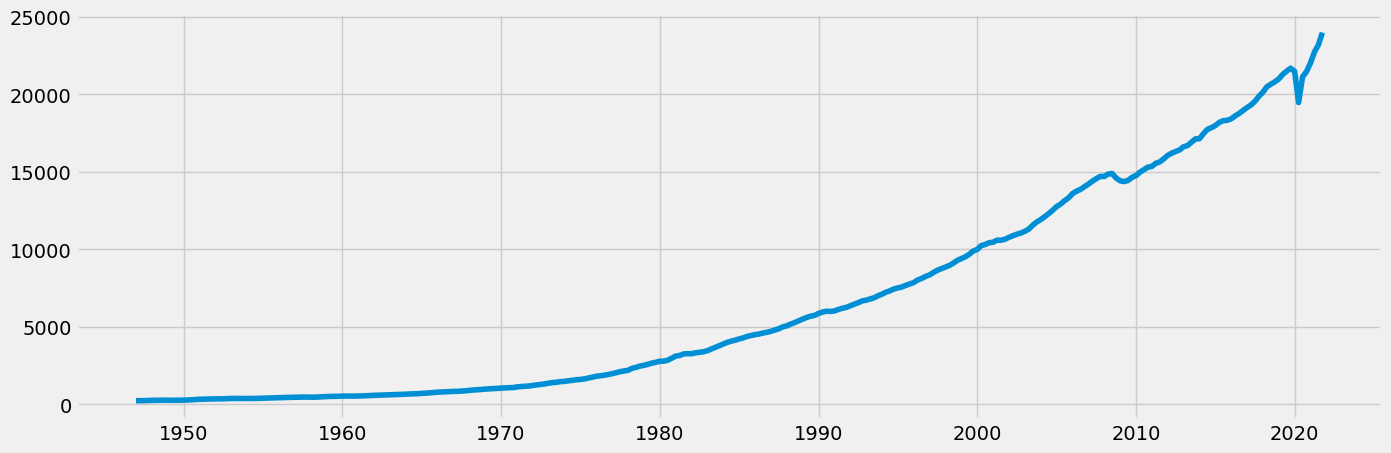

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
    

plt.plot(data)

2. Subsetting, wrangling, and cleaning time-series data

In [14]:
# Assuming your DataFrame is named 'Date'
df_GDP = data.reset_index()

In [15]:
df_GDP.head()

,Date,Value
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [20]:
sub_GDP = df_GDP.loc[(df_GDP['Date'] >= '2000-01-01')]

In [21]:
sub_GDP.shape

(88, 2)

In [22]:
sub_GDP.head()

,Date,Value
212,2000-01-01,10002.179
213,2000-04-01,10247.720
214,2000-07-01,10318.165
215,2000-10-01,10435.744
216,2001-01-01,10470.231


In [23]:
# Set the "Date" column as the index.

from datetime import datetime
sub_GDP['datetime'] = pd.to_datetime(sub_GDP['Date']) # Create a datetime column from Date
sub_GDP = sub_GDP.set_index('datetime')  # Set the datetime as the index of the dataframe
sub_GDP.drop(['Date'], axis=1, inplace=True) # Drop the Date column
sub_GDP.head()

,Value
datetime,
2000-01-01,10002.179
2000-04-01,10247.720
2000-07-01,10318.165
2000-10-01,10435.744
2001-01-01,10470.231


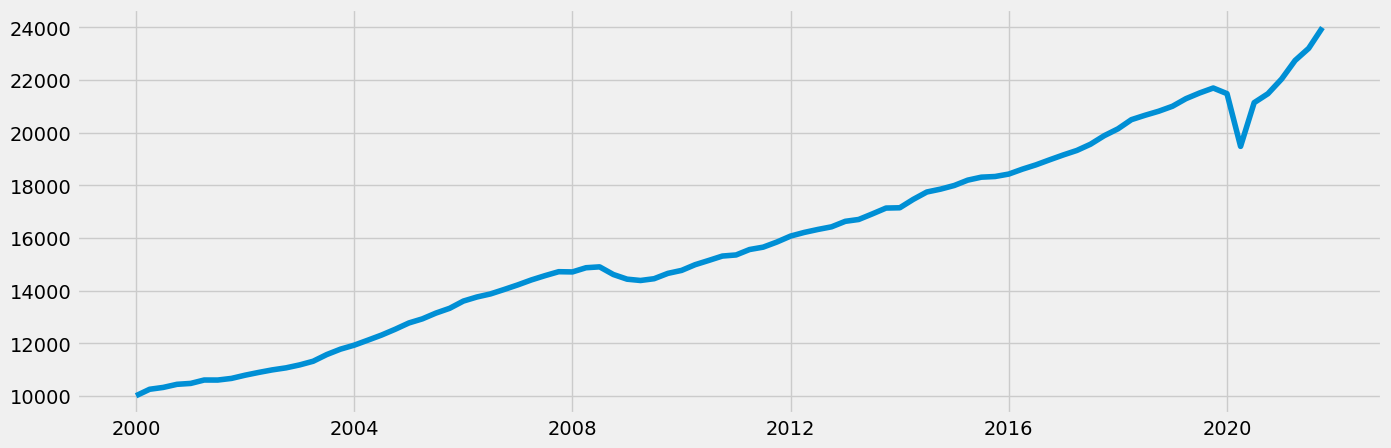

In [28]:
plt.figure(figsize=(15, 5))  # Set the figure size to 15 inches by 5 inches
plt.plot(sub_GDP)

In [29]:
# Check for missing values (you shouldn't have any)

sub_GDP.isnull().sum()

Value    0
dtype: int64

3. Time-series analysis: decomposition

In [30]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(sub_GDP, model='additive')

In [31]:
from pylab import rcParams # This will define a fixed size for all special charts,

rcParams['figure.figsize'] = 18, 7

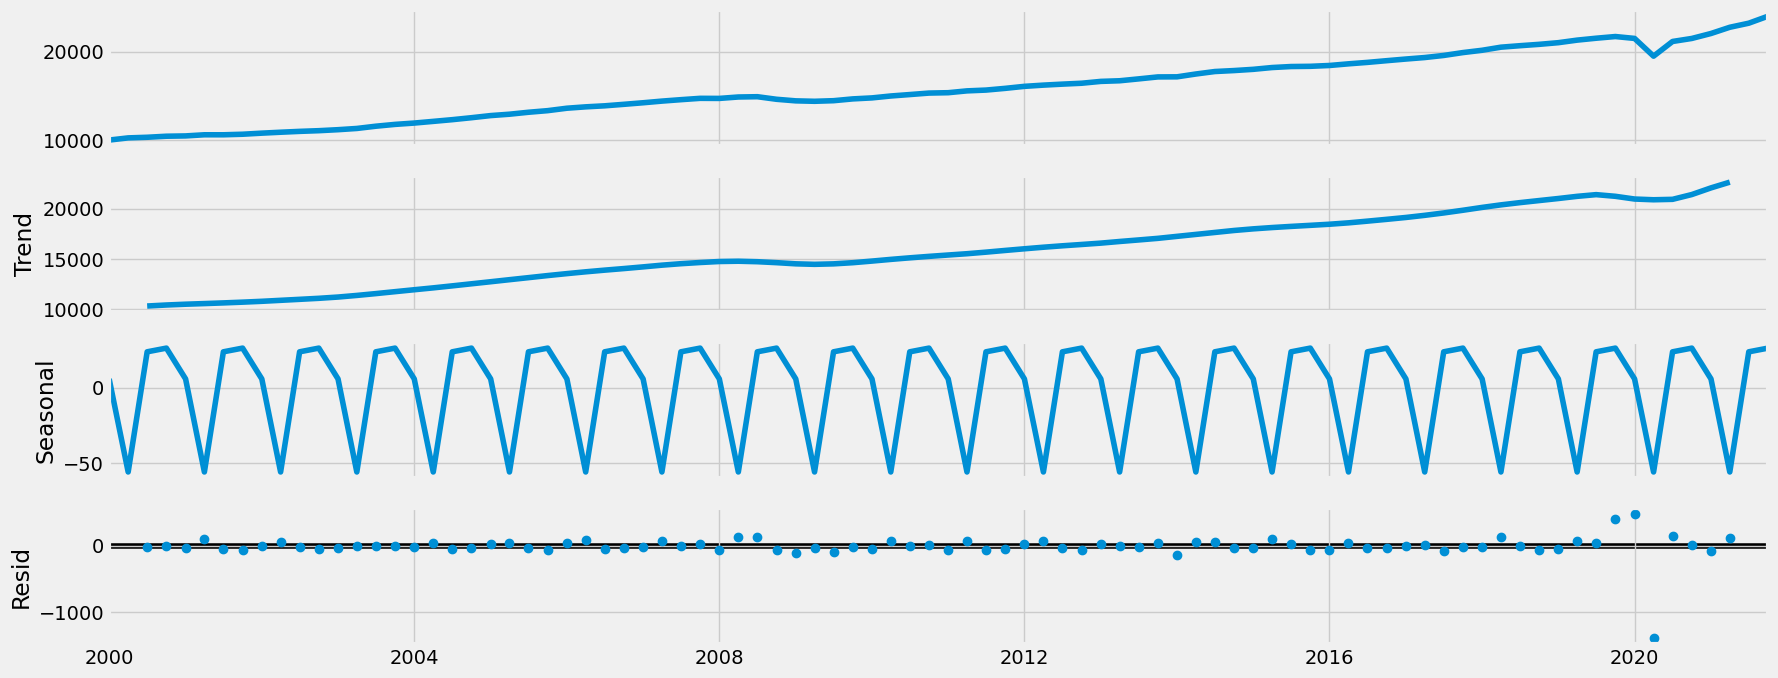

In [32]:
# Plot the separate components

decomposition.plot()
plt.show()

Observations:
- From the grafic plot we can see that there is a trend of increasin of GPD over the years, which means that also the growth rates are increasing.
- On the graphic we can see that there was just two litle decreasing of the GDP right after the economic crisis in 2008 and after 2019 due to COVID Pandemic.

4. Testing for stationarity

In [33]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return an array of numbers. This is why you need to also define a function that prints the correct output from that array,

from statsmodels.tsa.stattools import adfuller 
    
def dickey_fuller(timeseries): # Define the function,   
    
  # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
     result['Critical Value (%s)'%key] = value
     print (result)
# Apply the test using the function on the time series

dickey_fuller(sub_GDP['Value']) 

Dickey-Fuller Stationarity test:
Test Statistic                  1.057616
p-value                         0.994838
Number of Lags Used             0.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
dtype: float64
Test Statistic                  1.057616
p-value                         0.994838
Number of Lags Used             0.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
dtype: float64
Test Statistic                  1.057616
p-value                         0.994838
Number of Lags Used             0.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


 # There is a unit root in your data, and your data is non-stationary

First, p-value is greter than 0.5 (0.994838), which indicates the test result is not significant. We are using a significance level of 5 percent. So we need to look at the “Critical Value (5%)” in the results, which, in this example, has a value of -2.895382. This is much smaller than the test statistic, which is 1.057616, which means that you can’t reject the null hypothesis.

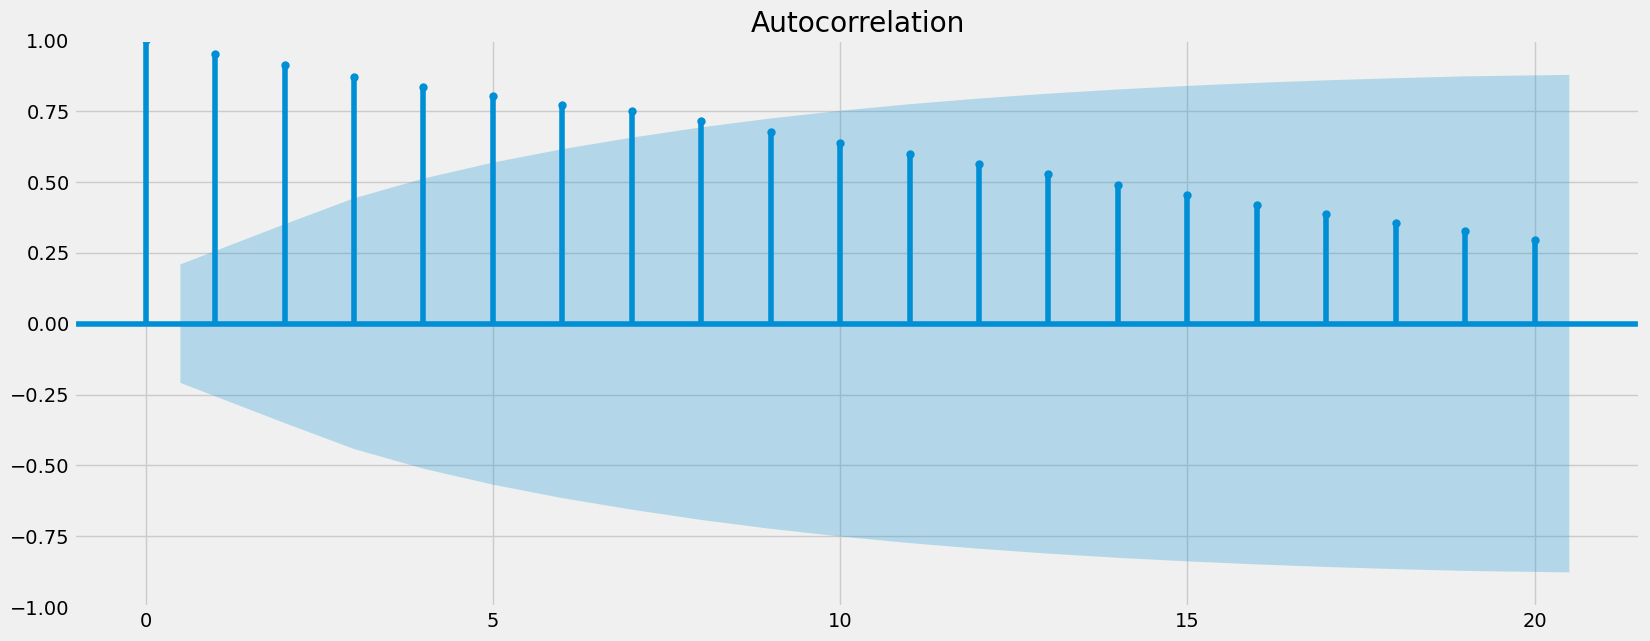

In [34]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots,

plot_acf(sub_GDP)
plt.show()

Observations:
The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means the lags are not significantly correlated with each other. We can deduce that this data is somewhat stationary.

5. Stationarizing the Federal Reserve Economic Data

In [35]:
GDP_diff = sub_GDP - sub_GDP.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [36]:
GDP_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing.
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [37]:
GDP_diff.head()

,Value
datetime,
2000-04-01,245.541
2000-07-01,70.445
2000-10-01,117.579
2001-01-01,34.487
2001-04-01,128.769


In [38]:
GDP_diff.columns

Index(['Value'], dtype='object')

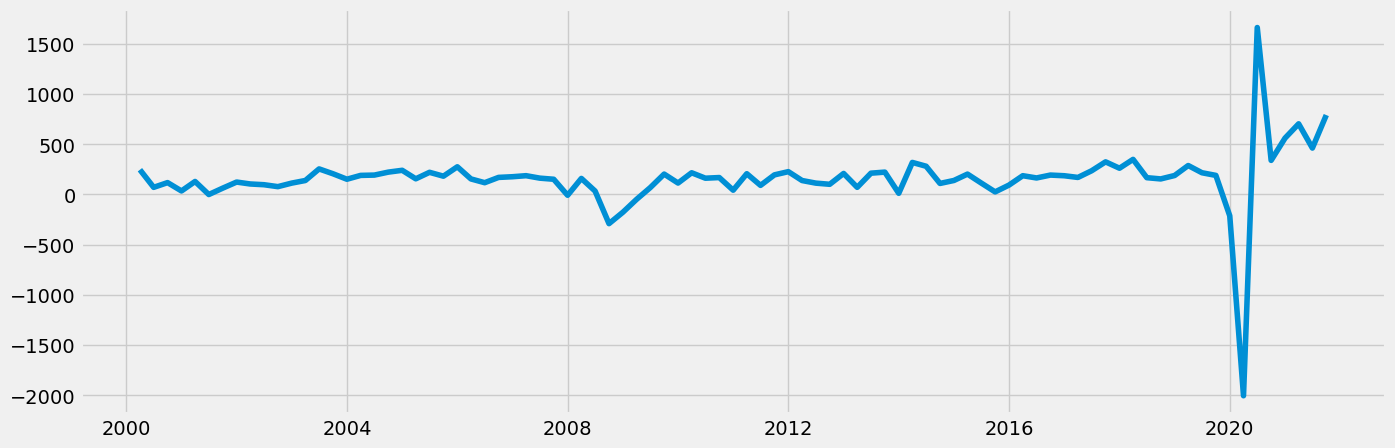

In [39]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(GDP_diff)

In [40]:
dickey_fuller(GDP_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.027129e+01
p-value                        3.995216e-18
Number of Lags Used            0.000000e+00
Number of Observations Used    8.600000e+01
Critical Value (1%)           -3.508783e+00
dtype: float64
Test Statistic                -1.027129e+01
p-value                        3.995216e-18
Number of Lags Used            0.000000e+00
Number of Observations Used    8.600000e+01
Critical Value (1%)           -3.508783e+00
Critical Value (5%)           -2.895784e+00
dtype: float64
Test Statistic                -1.027129e+01
p-value                        3.995216e-18
Number of Lags Used            0.000000e+00
Number of Observations Used    8.600000e+01
Critical Value (1%)           -3.508783e+00
Critical Value (5%)           -2.895784e+00
Critical Value (10%)          -2.585038e+00
dtype: float64


Observations:
After Stationarizing the GDP time series data using the Differencing method we found that test statistic is still larger than the critical value at both the five and ten percent significance levels. This means we cannot reject the null hypothesis and, as a result, consider GDP data series non-stationary.

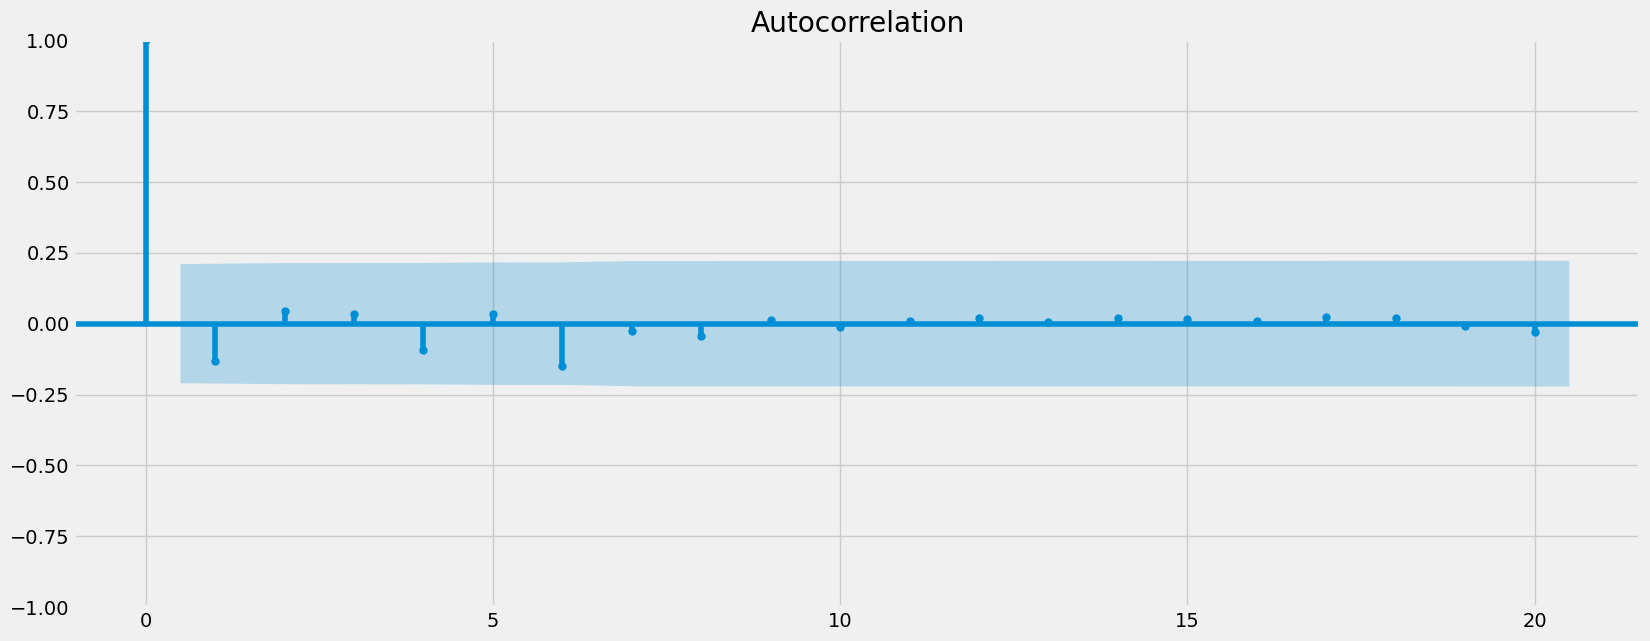

In [41]:
plot_acf(GDP_diff)
plt.show()

While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect.

6. Again stationarizing the Federal Reserve Economic Data

In [42]:
GDP_diff1 = GDP_diff - GDP_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [43]:
GDP_diff1.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing.
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [44]:
GDP_diff1.head()

,Value
datetime,
2000-07-01,-175.096
2000-10-01,47.134
2001-01-01,-83.092
2001-04-01,94.282
2001-07-01,-129.749


In [45]:
GDP_diff1.columns

Index(['Value'], dtype='object')

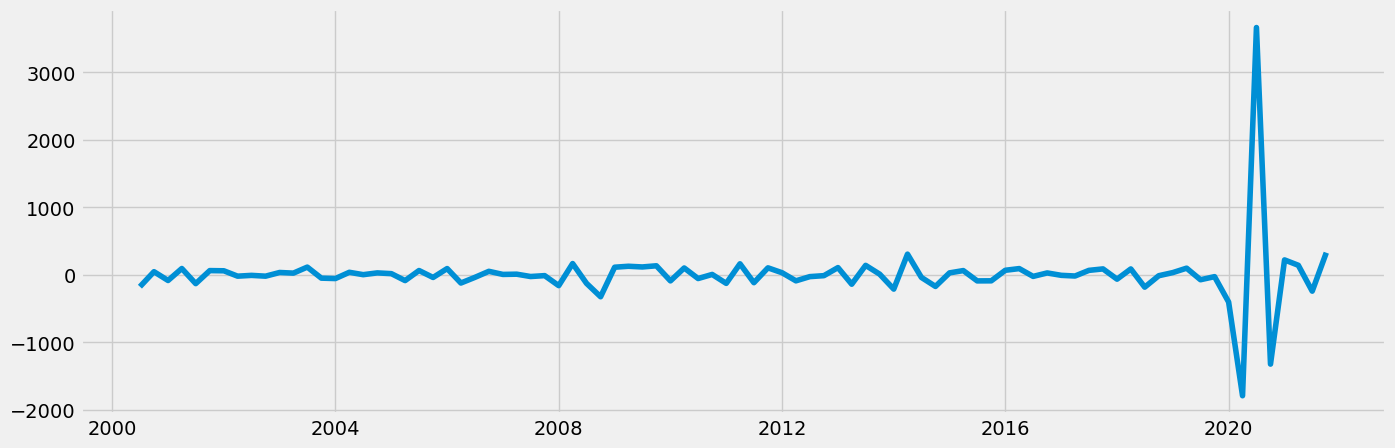

In [46]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(GDP_diff1)

In [47]:
dickey_fuller(GDP_diff1)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.251496
p-value                         0.000538
Number of Lags Used             7.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
dtype: float64
Test Statistic                 -4.251496
p-value                         0.000538
Number of Lags Used             7.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
dtype: float64
Test Statistic                 -4.251496
p-value                         0.000538
Number of Lags Used             7.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
Critical Value (10%)           -2.586955
dtype: float64


Observation: After Stationarizing for second time the GDP time series data using the Differencing method we found that test statistic is now smaller than the critical value at both the five and ten percent significance levels. This means we can reject the null hypothesis and, as a result, consider GDP data series stationary.

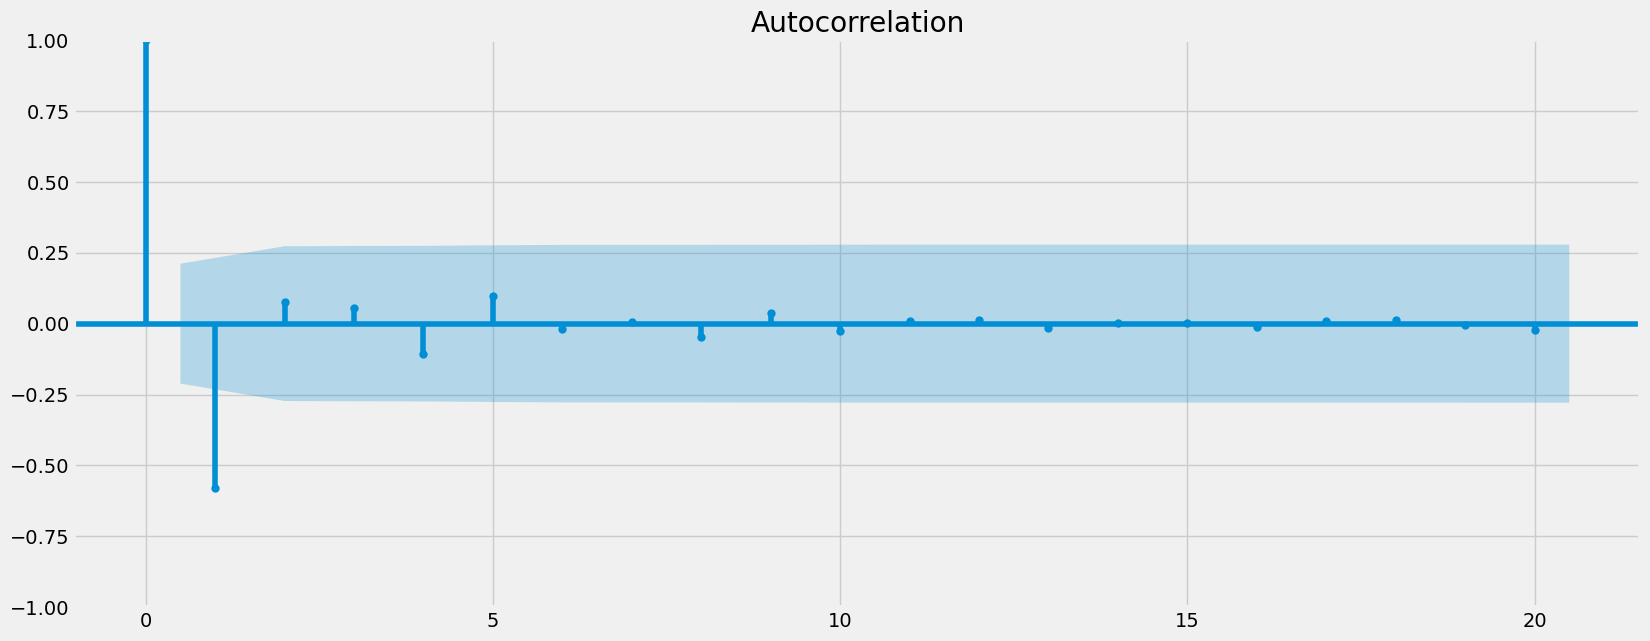

In [48]:
plot_acf(GDP_diff1)
plt.show()

## Observations:
While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect. This means that, despite the Dickey-Fuller test saying that data is stationary, that stationarity is weak